<a href="https://colab.research.google.com/github/dmartmillan/DeepLearningSpotNuclei/blob/main/template_final3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from PIL import Image
from IPython.display import Image as DPImage
import os
import numpy as np
from random import sample
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn as sk
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import random
import csv
import skimage

from sklearn.model_selection import train_test_split


from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, Concatenate, UpSampling2D
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.optimizers import Adam, SGD
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.models import load_model, Model
from tensorflow.keras import Input
import keras.backend as K
# from google.colab import drive
# drive.mount('/content/gdrive')
# import sys
# sys.path.insert(0,'/content/gdrive/My Drive/Colab Notebooks')
# data_loc = '/content/gdrive/My Drive/data'
data_loc = './data'
from data_processing import data_grinder

seed = 2023
np.random.seed(seed)  

## 0. Some functions

In [2]:
def plot_history(history, steps_per_epoch = 0, y_axis_lower_bound = -1):
    
    if steps_per_epoch >0:
        xvals = int(steps_per_epoch)*np.array(history.epoch)
        xlab = 'Weight update steps'
    else:
        xvals = np.array(history.epoch)
        xlab = 'Epochs'


    plt.figure(figsize = (12,4))
    plt.subplot(1,2,1)
    plt.xlabel(xlab)
    plt.ylabel('Accuracy')
    plt.plot(xvals, np.array(history.history['mean_iou']),'g-', 
             label='Train IoU')
    plt.plot(xvals, np.array(history.history['val_mean_iou']),'r-',
             label = 'Validation IoU')
    if y_axis_lower_bound>-1:
        plt.ylim([y_axis_lower_bound,1])
    plt.legend()

    plt.subplot(1,2,2)
    plt.xlabel(xlab)
    plt.ylabel('Loss minimised by model')
    plt.plot(xvals, np.array(history.history['loss']),'g-', 
             label='Train loss')
    plt.plot(xvals, np.array(history.history['val_loss']),'r-',
             label = 'Validation loss')
    plt.legend()

def iou(y_true, y_pred):
        y_true = tf.cast(y_true, y_pred.dtype)
        intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
        union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3]) - intersection
        iou = K.mean((intersection + 1) / (union + 1), axis=0)
        return iou
def mean_iou(y_true, y_pred):
    results = []   
    for t in np.arange(0.5, 1, 0.05):
        t_y_pred = tf.cast((y_pred > t), tf.float32)
        pred = iou(y_true, t_y_pred)
        results.append(pred)
        
    return K.mean(K.stack(results), axis=0)

def diceloss(y_true, y_pred, smooth=1e-6):
    
    #flatten label and prediction tensors
        y_true = tf.cast(y_true, y_pred.dtype)
        intersection = K.sum(K.abs(y_true * y_pred))
        dice = (2*intersection + smooth) / (K.sum(y_true) + K.sum(y_pred) + smooth)
        return 1 - dice

## 1. Load images

In [4]:
import pickle
data_set = open(f'{data_loc}/data_set.obj', 'rb')
data_dict = pickle.load(data_set)
data_set.close()
train_dict = data_dict['train_dict']
val_dict = data_dict['val_dict']
test_dict = data_dict['test_dict']
data_dict.clear()

## 2. Pre-processing

### 2.1 Procedure

In [5]:
train_set = data_grinder(train_dict)
val_set = data_grinder(val_dict)
train_set.preprocessImages()
val_set.preprocessImages()

2023-05-11 17:29:06.278584: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78997 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:41:00.0, compute capability: 8.0
2023-05-11 17:29:06.295594: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 78997 MB memory:  -> device: 1, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:81:00.0, compute capability: 8.0


### 2.2 Display images

Image, processed image and mask from data set No. 533 with size (360, 360): c8ca945abc29d262a5525e4c2585541bba33fa77c86a47c94575d8e5b54c83fb


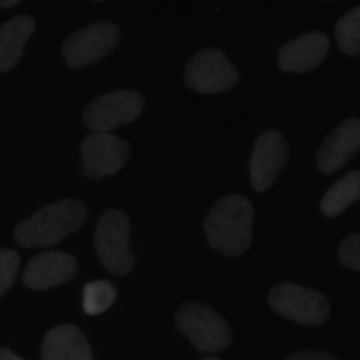

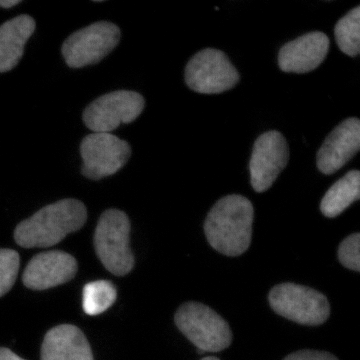

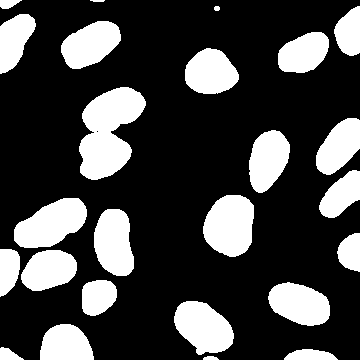

In [6]:
# display
train_set.display_imgs(ix0= 533) # without ix0 input, it will give a random index

## 3. Pre-processing

In [7]:
train_set.croporresizeImages()
val_set.croporresizeImages()

### 3.2 Display images

Processed image and mask from train set No. 393 with size (696, 520): 958114e5f37d5e1420b410bd716753b3e874b175f2b6958ebf1ec2bdf776e41f


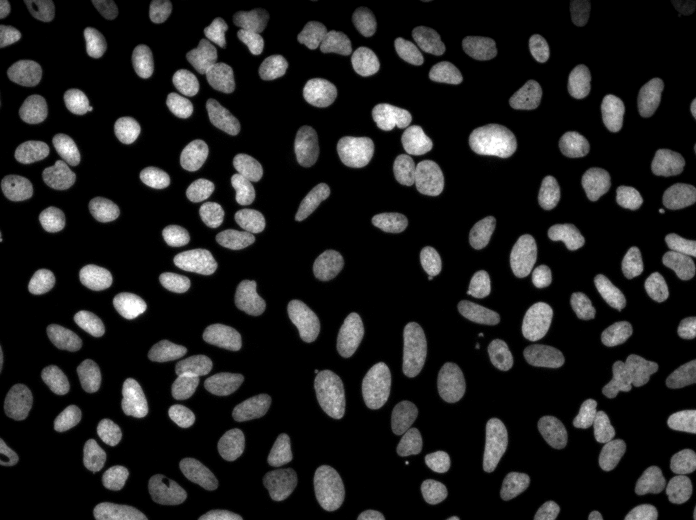

It crops to 30 masks with size (128, 128, 1)
cropped image and mask: 1


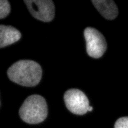

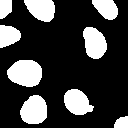

cropped image and mask: 2


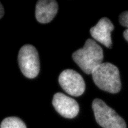

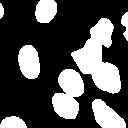

cropped image and mask: 3


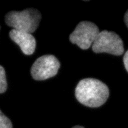

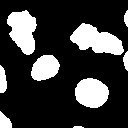

cropped image and mask: 4


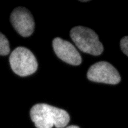

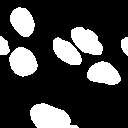

cropped image and mask: 5


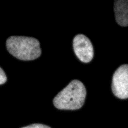

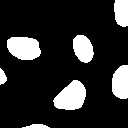

cropped image and mask: 6


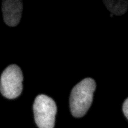

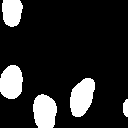

cropped image and mask: 7


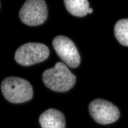

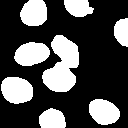

cropped image and mask: 8


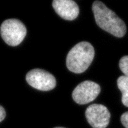

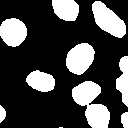

cropped image and mask: 9


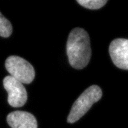

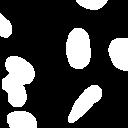

cropped image and mask: 10


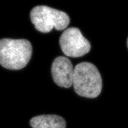

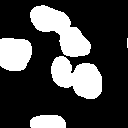

cropped image and mask: 11


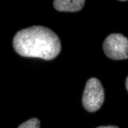

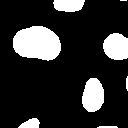

cropped image and mask: 12


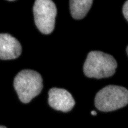

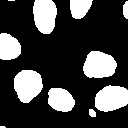

cropped image and mask: 13


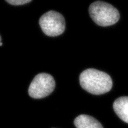

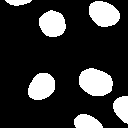

cropped image and mask: 14


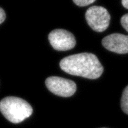

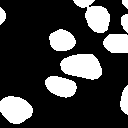

cropped image and mask: 15


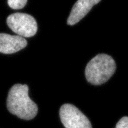

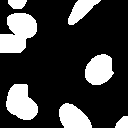

cropped image and mask: 16


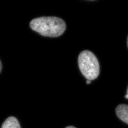

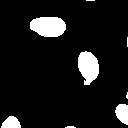

cropped image and mask: 17


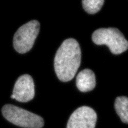

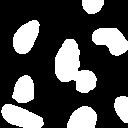

cropped image and mask: 18


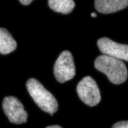

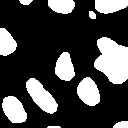

cropped image and mask: 19


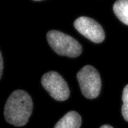

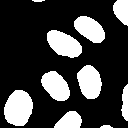

cropped image and mask: 20


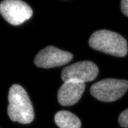

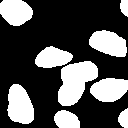

cropped image and mask: 21


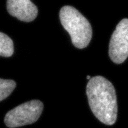

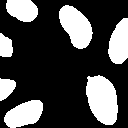

cropped image and mask: 22


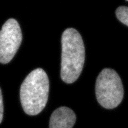

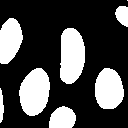

cropped image and mask: 23


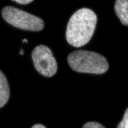

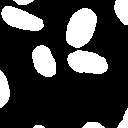

cropped image and mask: 24


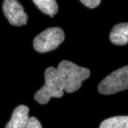

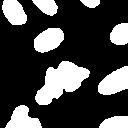

cropped image and mask: 25


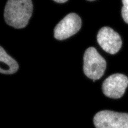

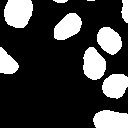

cropped image and mask: 26


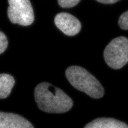

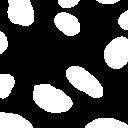

cropped image and mask: 27


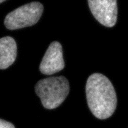

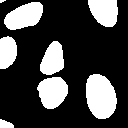

cropped image and mask: 28


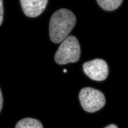

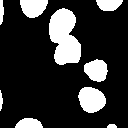

cropped image and mask: 29


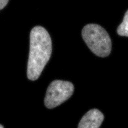

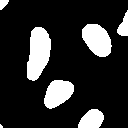

cropped image and mask: 30


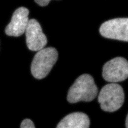

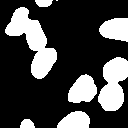

In [8]:
# display
train_set.display_crops() # without ix0 input, it will give a random index

## 4. Test the rejoin function

Image and mask from data set No. 661 with size (256, 256): fc9269fb2e651cd4a32b65ae164f79b0a2ea823e0a83508c85d7985a6bed43cf
Original image


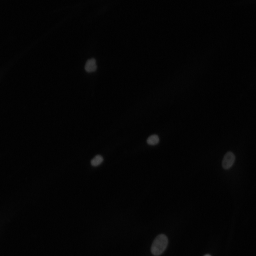

Processed image


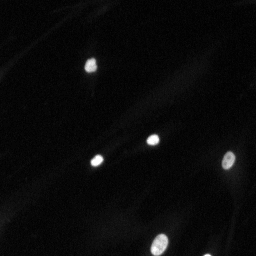

Original mask


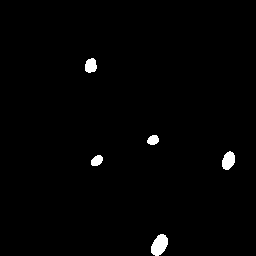

Rejoined mask


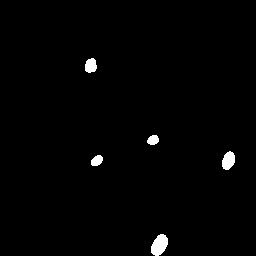

In [9]:
Y_pred_train = train_dict['Y']
train_set.rejoinMask(Y_pred_train)
train_set.display_rejoinmasks() # without ix0 input, it will give a random index

## 5. UNET model

### 5.1 Prepare data

In [15]:
train_set.list2array()
val_set.list2array()
X_train0, Y_train = train_set.data_dict['X_array'], train_set.data_dict['Y_array']
X_val0, Y_val = val_set.data_dict['X_array'], val_set.data_dict['Y_array']

X_train = tf.keras.applications.mobilenet_v2.preprocess_input(X_train0)
X_val = tf.keras.applications.mobilenet_v2.preprocess_input(X_val0)
print(f'X_train shape:, {X_train.shape}; Y_train shape:, {Y_train.shape}')
print(f'X_val shape:, {X_val.shape}; Y_val shape:, {Y_val.shape}')

X_train shape:, (7315, 128, 128, 3); Y_train shape:, (7315, 128, 128, 1)
X_val shape:, (812, 128, 128, 3); Y_val shape:, (812, 128, 128, 1)


### 5.2 Model setup

In [21]:
# Encoder

base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)
base_model.summary()
print(str(base_model.get_layer(index=1)))

Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 64, 64, 32)   864         ['input_7[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 64, 64, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 64, 64, 32)   0           ['bn_Conv1[0][

In [66]:
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    #x = Dropout(rate=0.2)(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    #x = Dropout(rate=0.5)(x)

    return x

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def create_model(input_shape, LR):
    inputs = Input(input_shape)
    
    mobilenetv2 = tf.keras.applications.MobileNetV2(input_shape=input_shape, input_tensor=inputs, include_top=False, weights='imagenet')
    mobilenetv2.trainable = False
    
    s1 = mobilenetv2.get_layer(index=0).output                  # 128x128
    s2 = mobilenetv2.get_layer('block_1_expand_relu').output    # 64x64
    s3 = mobilenetv2.get_layer('block_3_expand_relu').output    # 32x32
    s4 = mobilenetv2.get_layer('block_6_expand_relu').output    # 16x16
    s5 = mobilenetv2.get_layer('block_13_expand_relu').output   # 8x8
    
    b1 = mobilenetv2.get_layer('block_16_project').output       # 4x4

    d1 = decoder_block(b1, s5, 512)
    d2 = decoder_block(d1, s4, 256)
    d3 = decoder_block(d2, s3, 128)
    d4 = decoder_block(d3, s2, 64)
    d5 = decoder_block(d4, s1, 32)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d5)

    model = Model(inputs=inputs, outputs=outputs)

    model.compile(optimizer=Adam(learning_rate=LR),loss=diceloss, metrics=[mean_iou])

    return model

### 5.3 Parameters

In [67]:
epochs = 20
batch_size = 32
LR = 0.001

#early_stopping = EarlyStopping(patience=10, verbose=1)
#model_checkpoint = ModelCheckpoint(f"{data_loc}/keras.model", save_best_only=True, verbose=1)
#reduce_lr = ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1)

model = create_model((128,128,3), LR)
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_17 (InputLayer)          [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 64, 64, 32)   864         ['input_17[0][0]']               
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 64, 64, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 64, 64, 32)   0           ['bn_Conv1[0][0]']         

### 5.4 Training

Note: No early stopping because validation set is too small

In [68]:
history = model.fit(X_train, Y_train,
                    validation_data=[X_val, Y_val], 
                    epochs=epochs,
                    batch_size=batch_size,
                    #callbacks=[early_stopping, model_checkpoint, reduce_lr],
                    shuffle=True)

Epoch 1/20
229/229 [==============================] - 10s 31ms/step - loss: 0.1900 - mean_iou: 0.7958 - val_loss: 0.2173 - val_mean_iou: 0.7140
Epoch 2/20
229/229 [==============================] - 6s 27ms/step - loss: 0.0887 - mean_iou: 0.8321 - val_loss: 0.2779 - val_mean_iou: 0.6560
Epoch 3/20
229/229 [==============================] - 6s 27ms/step - loss: 0.0739 - mean_iou: 0.8505 - val_loss: 0.1858 - val_mean_iou: 0.7296
Epoch 4/20
229/229 [==============================] - 6s 27ms/step - loss: 0.0687 - mean_iou: 0.8585 - val_loss: 0.2933 - val_mean_iou: 0.5717
Epoch 5/20
229/229 [==============================] - 6s 27ms/step - loss: 0.0688 - mean_iou: 0.8578 - val_loss: 0.1859 - val_mean_iou: 0.7350
Epoch 6/20
229/229 [==============================] - 6s 27ms/step - loss: 0.0651 - mean_iou: 0.8632 - val_loss: 0.1746 - val_mean_iou: 0.7537
Epoch 7/20
229/229 [==============================] - 6s 27ms/step - loss: 0.0631 - mean_iou: 0.8705 - val_loss: 0.1908 - val_mean_iou: 0.732

In [43]:
save_path = "./data/mobilenetv2-initial-test"
model.save(save_path)

INFO:tensorflow:Assets written to: ./data/mobilenetv2-initial-test-out-relu-bridge/assets


/apps/gent/RHEL8/zen3-ampere-ib/software/TensorFlow/2.7.1-foss-2021b-CUDA-11.4.1/lib/python3.9/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/apps/gent/RHEL8/zen3-ampere-ib/software/TensorFlow/2.7.1-foss-2021b-CUDA-11.4.1/lib/python3.9/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


### 5.5 Model evaluation

Training set IoU: 0.8759
Training set Loss:0.063211

Validation set IoU: 0.7430
Validation set Loss:0.157070



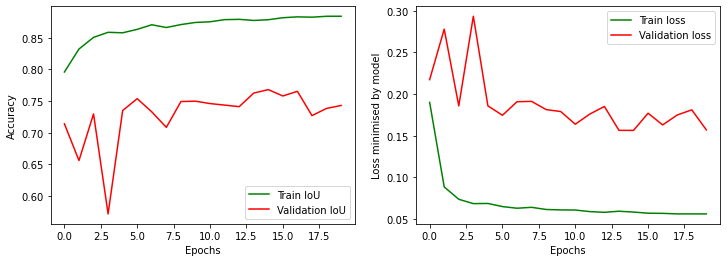

In [69]:
[train_loss, train_IoU] = model.evaluate(X_train, Y_train, verbose=0)
print("Training set IoU:{:7.4f}".format(train_IoU))
print("Training set Loss:{:7.6f}\n".format(train_loss))

[val_loss, val_IoU] = model.evaluate(X_val, Y_val, verbose=0)
print("Validation set IoU:{:7.4f}".format(val_IoU))
print("Validation set Loss:{:7.6f}\n".format(val_loss))

plot_history(history)
#plt.savefig(f"{save_path}/history_plots.png")

In [70]:
# optional load model
model = tf.keras.models.load_model("./data/mobilenetv2-initial-test", custom_objects = {"mean_iou": mean_iou, "diceloss": diceloss})

In [71]:
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_val, verbose=1)

preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

26/26 [==============================] - 0s 9ms/step


Image


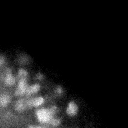

Mask


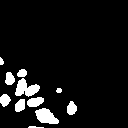

Prediction


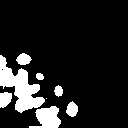

309


In [72]:
ix = random.randint(0, len(preds_val_t))
ix = 309
print("Image")
display(keras.preprocessing.image.array_to_img(X_val0[ix]*255))
print("Mask")
display(keras.preprocessing.image.array_to_img(Y_val[ix]))
print("Prediction")
display(keras.preprocessing.image.array_to_img(preds_val_t[ix]))
print(ix)

### 5.6 Calculate IoU for Validation set

In [73]:
train_set.rejoinMask(preds_train)
val_set.rejoinMask(preds_val)

train_set.cal_iou()
print("Train set IoU:{:7.4f}".format(train_set.mean_iou))
val_set.cal_iou()
print("Validation set IoU:{:7.4f}".format(val_set.mean_iou))

Train set IoU: 0.8701
Validation set IoU: 0.7792


### 5.7 Test evaluation (to be updated)

In [ ]:
test_set = data_grinder(test_dict)
test_set.preprocessImages()
test_set.croporresizeImages(hasmask = False)
test_set.list2array()
X_test0 = test_set.data_dict['X_array']

X_test = X_test0[:,:,:,0]/255 # standardization

In [ ]:
preds_test = model.predict(X_test, verbose=1)
preds_test_t = (preds_test > 0.5).astype(np.uint8)
test_set.rejoinMask(preds_test)

1335/1335 [==============================] - 33s 25ms/step


In [ ]:
imageIDs = test_set.data_dict['imageIDs']
ix = random.randint(0, len(imageIDs) - 1)
display(test_set.data_dict['images'][ix])
display(test_set.data_dict['cal_masks'][ix])

## 6. Export to EXCEL